# Depth estimation

## Depth from disparity using [8 point algorithm](https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html) 
double check link^

In [1]:
# Imports
import numpy as np
import cv2  
import matplotlib.pyplot as plt

In [2]:
# Select 2 images for feature matching
img_left = cv2.imread('../data/color_matched/Seimon_4K_calibrated_2024_corrected_81705.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('../data/color_matched/Schyma_4K_calibrated_81705.png', cv2.IMREAD_GRAYSCALE)

In [27]:
# # Code for manually collecting points in images (CP)

# # Define the callback function
# def get_pixel_coordinates(event, x, y, flags, param):
#     if event == cv2.EVENT_LBUTTONDOWN:  # Check if the left mouse button was clicked
#         print(f"({x}, {y})")

# # Read the image
# img = img2

# # Display the image in a window
# cv2.namedWindow('Image', cv2.WINDOW_NORMAL)
# cv2.imshow('Image', img)

# # Resize the window to fit the whole image but be in a smaller panel
# height, width = img.shape[:2]
# cv2.resizeWindow('Image', width // 2, height // 2)

# # Set the mouse callback function to get_pixel_coordinates
# cv2.setMouseCallback('Image', get_pixel_coordinates)

# # Wait until a key is pressed
# cv2.waitKey(0)

# # Destroy all windows
# cv2.destroyAllWindows()

Feature matching

In [28]:
# plt.figure(figsize=(20, 10))
# plt.axis('off')
# plt.imshow(img1)
# pts = [(1360, 1011),
# (1395, 1092),
# (1412, 1196),
# (1845, 1525),
# (1960, 1411),
# (2085, 1035),
# (602, 866),
# (525, 850)]

# plt.scatter([i[0] for i in pts], [i[1] for i in pts])
    
# for i, pt in enumerate(pts):
#     plt.text(pt[0], pt[1], str(i), color='red', fontsize=12)

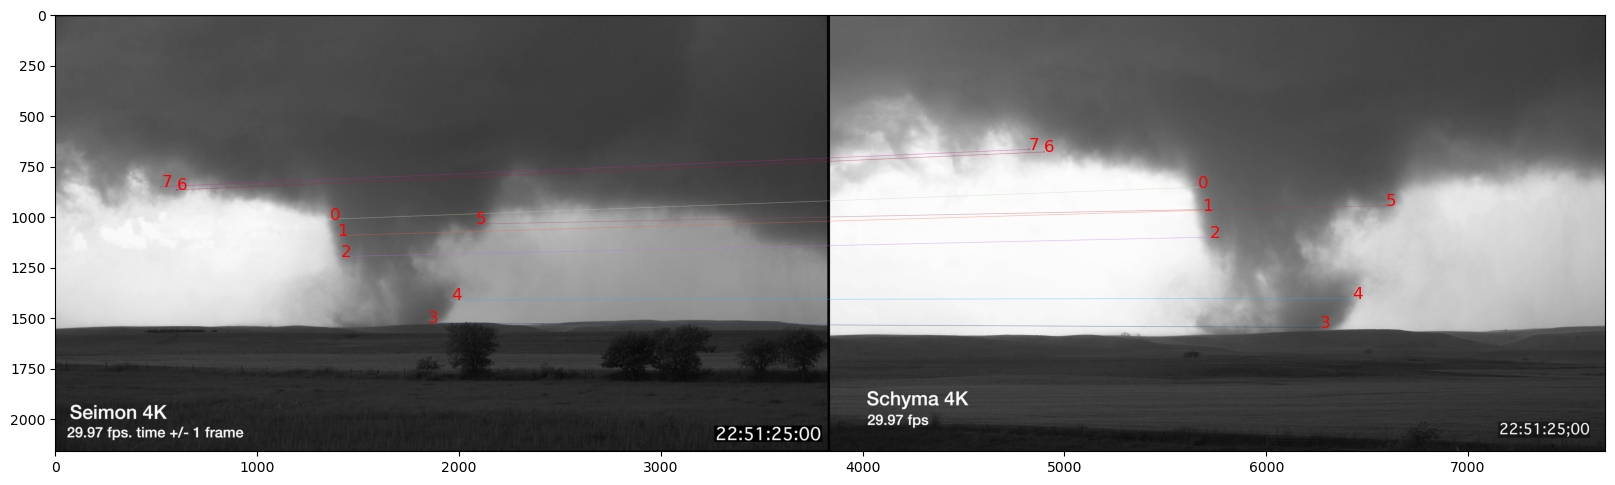

In [4]:
# # Collected points
# pts1 = [(624, 725), (1024, 656), (1230, 702), (1370, 737), (1802, 879), (1850, 1105),
#  (2616, 1010), (3320, 800)] 
# pts2 = [(2474, 1488), (2707, 893), (1017, 667), (1796, 802), (1842, 1548), (1472, 1579), (3476, 1626), (3025, 1590), (2297, 1196), (3051, 741), (1401, 736)]

pts2 = [
(1820, 853),
(1842, 967),
(1878, 1100),
(2425, 1547),
(2585, 1403),
(2752, 945),
(1060, 678),
(985, 665)
]

pts1 = [
(1360, 1011),
(1395, 1092),
(1412, 1196),
(1845, 1525),
(1960, 1411),
(2085, 1035),
(602, 866),
(525, 850)
] # check coordinates #TODO


# Convert points to numpy arrays
pts1 = np.array(pts1)
pts2 = np.array(pts2)

# Draw the matches between the images
img_matches = cv2.drawMatches(img_left, [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in pts1], 
                              img_right, [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in pts2], 
                              [cv2.DMatch(i, i, 0) for i in range(len(pts1))], None)

# Display the matches
plt.figure(figsize=(20, 10))
plt.imshow(img_matches)

# Annotate the points with their index numbers
for i, (pt1, pt2) in enumerate(zip(pts1, pts2)):
    plt.text(pt1[0], pt1[1], str(i), color='red', fontsize=12)
    plt.text(pt2[0] + img_left.shape[1], pt2[1], str(i), color='red', fontsize=12)

plt.show()


Text(0.5, 1.0, 'Disparity')

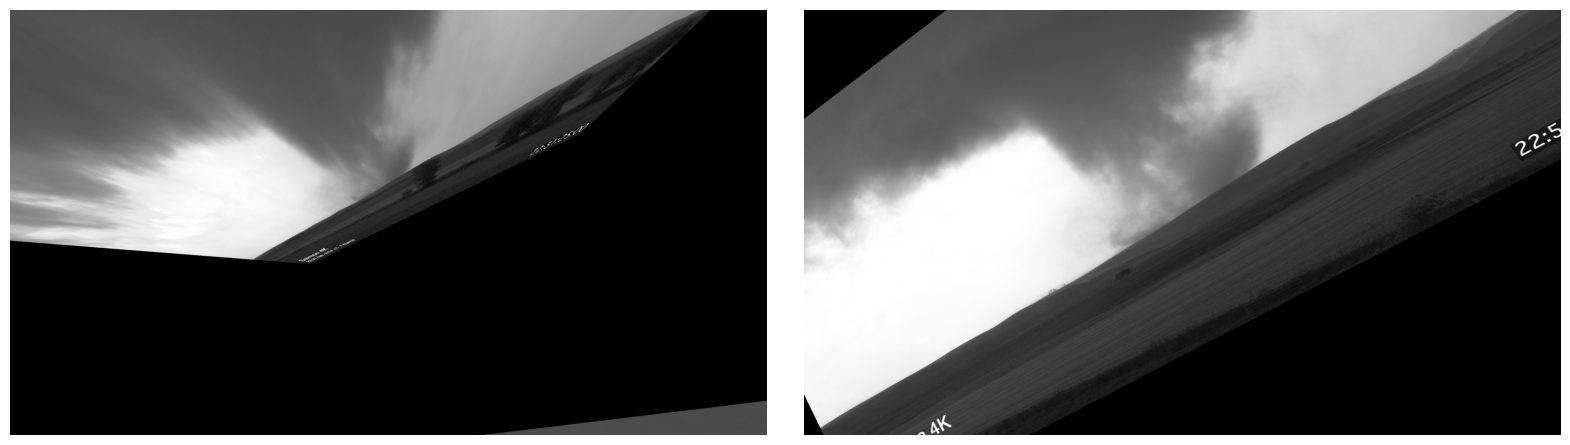

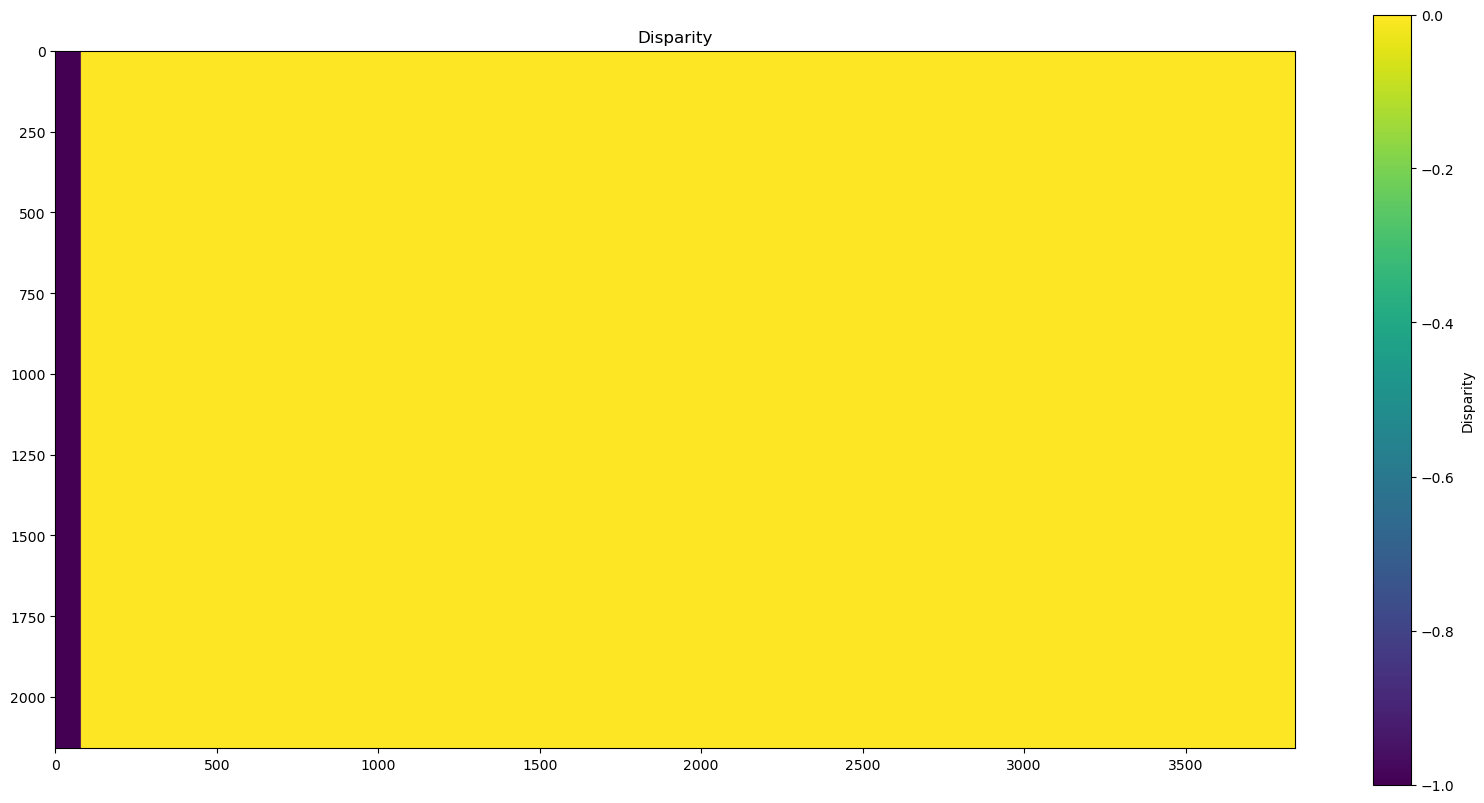

In [ ]:
# Find the fundamental matrix using the 8-point algorithm
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC) # more points!

# # Obtain camera matrices
_, H1, H2 = cv2.stereoRectifyUncalibrated(pts1, pts2, F, )
h1,w1 = img_left.shape[:2]
h2,w2 = img_right.shape[:2]
img1_rectified = cv2.warpPerspective(img_left, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(img_right, H2, (w2, h2))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.05)  # Reduce the margin between images
axs[0].imshow(img1_rectified, cmap='gray')
axs[0].axis('off')  # Remove axis
axs[1].imshow(img2_rectified, cmap='gray')
axs[1].axis('off')  # Remove axis

# Proceed with disparity computation (unchanged from previous code)
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16 * 5,
    blockSize=25,
    P1=8 * 3 * 25 ** 2,
    P2=32 * 3 * 25 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=50,
    speckleRange=32
)
disparity = stereo.compute(img1_rectified, img1_rectified).astype(np.float32) / 16.0
plt.figure(figsize=(20, 10))
plt.imshow(disparity, cmap='viridis')

plt.colorbar(label='Disparity')
plt.title("Disparity")



Text(0.5, 1.0, 'Right Image (rectified)')

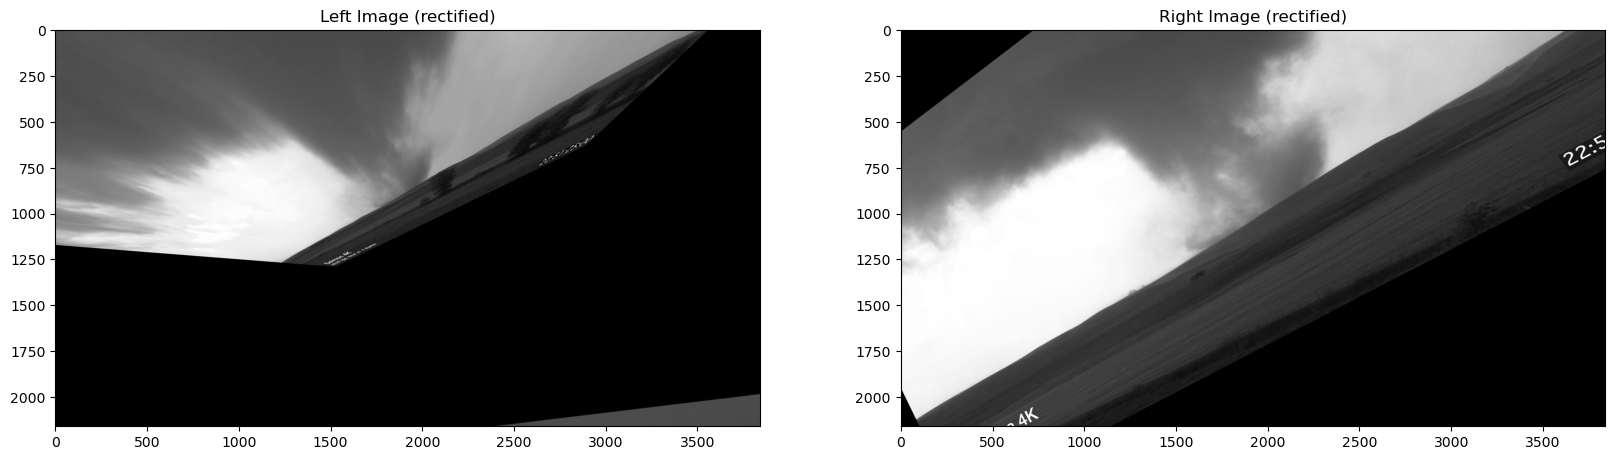

In [8]:
# Rectify the images
img_left_rect = cv2.warpPerspective(img_left, H1, (img_left.shape[1], img_left.shape[0]))
img_right_rect = cv2.warpPerspective(img_right, H2, (img_right.shape[1], img_right.shape[0]))

# Display the rectified images
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img_left_rect, cmap='gray')
axs[0].set_title('Left Image (rectified)')
axs[1].imshow(img_right_rect, cmap='gray')
axs[1].set_title('Right Image (rectified)')


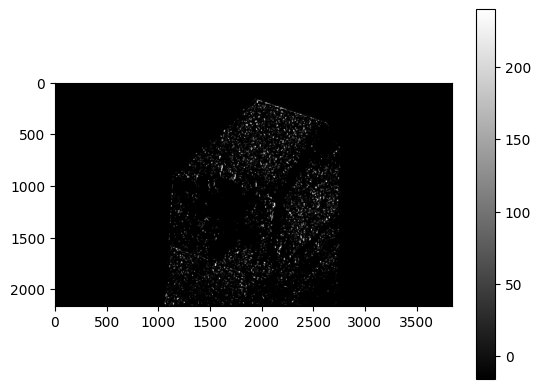

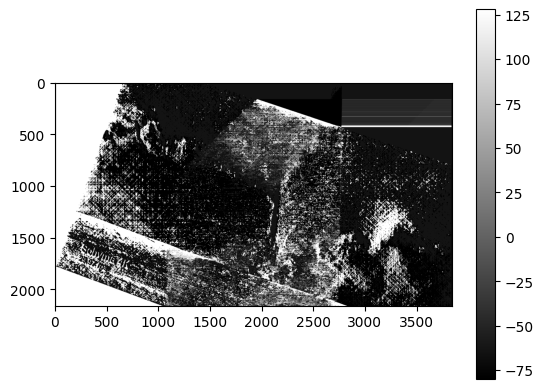

In [36]:
# Using StereoBM
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_BM = stereo.compute(img_left_rect, img_right_rect)
plt.imshow(disparity_BM, "gray")
plt.colorbar()
plt.show()

# Using StereoSGBM
# Set disparity parameters. Note: disparity range is tuned according to
#  specific parameters obtained through trial and error.
win_size = 2
min_disp = -4
max_disp = 9
num_disp = max_disp - min_disp  # Needs to be divisible by 16
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=5,
    uniquenessRatio=5,
    speckleWindowSize=5,
    speckleRange=5,
    disp12MaxDiff=2,
    P1=8 * 3 * win_size ** 2,
    P2=32 * 3 * win_size ** 2,
)
disparity_SGBM = stereo.compute(img_left_rect, img_right_rect)
plt.imshow(disparity_SGBM, "gray")
plt.colorbar()
plt.show()

(np.float64(-0.5), np.float64(3839.5), np.float64(1859.5), np.float64(-0.5))

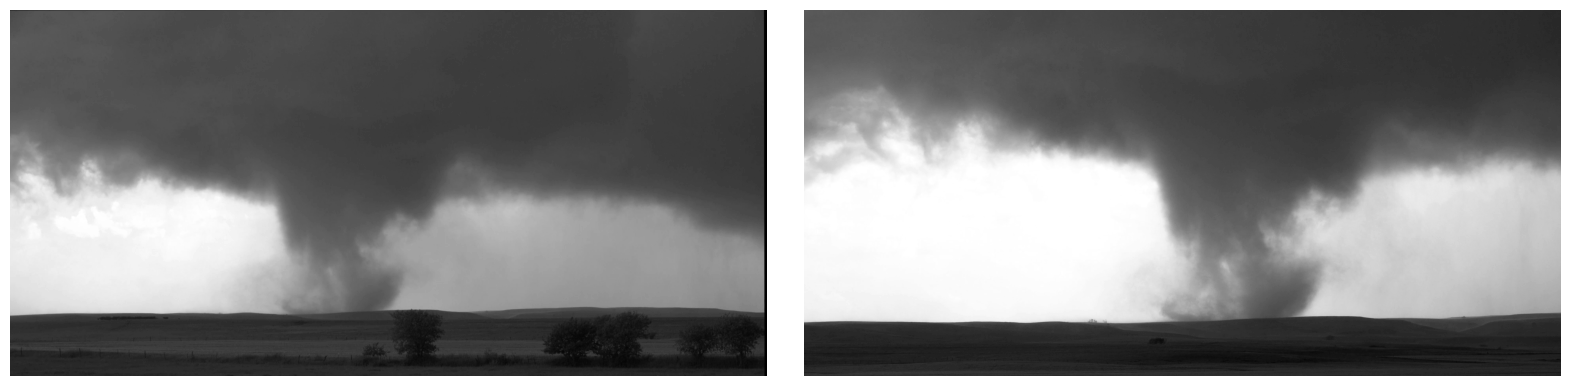

In [18]:

# Stereo calibration data (example values; replace with actual calibration results)
K1 = np.array([[1000.0, 0.0, img_left.shape[0]//2], [0.0, 1000, img_left.shape[1]//2], [0.0, 0.0, 1.0]])
K2 = np.array([[1000.0, 0.0, img_left.shape[0]//2], [0.0, 1000, img_left.shape[1]//2], [0.0, 0.0, 1.0]])
D1 = np.zeros(5)  # Distortion for left camera
D2 = np.zeros(5)  # Distortion for right camera
R = np.eye(3)  # Rotation matrix between cameras
T = np.array([0.1, 0, 0])  # Translation vector between cameras
# Perform stereo rectification
image_size = img_left.shape[::-1]  # (width, height)
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(K1, D1, K2, D2, image_size, R, T, flags=cv2.CALIB_ZERO_DISPARITY)
# Compute rectification maps
map1x, map1y = cv2.initUndistortRectifyMap(K1, D1, R1, P1, image_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(K2, D2, R2, P2, image_size, cv2.CV_32FC1)
# Rectify the images
rectified_left = cv2.remap(img_left, map1x, map1y, cv2.INTER_LINEAR)
rectified_right = cv2.remap(img_right, map2x, map2y, cv2.INTER_LINEAR)
# Display rectified 

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.05)  # Reduce the margin between images
axs[0].imshow(rectified_left, cmap='gray')
axs[0].axis('off')  # Remove axis
axs[1].imshow(rectified_right, cmap='gray')
axs[1].axis('off')  # Remove axis


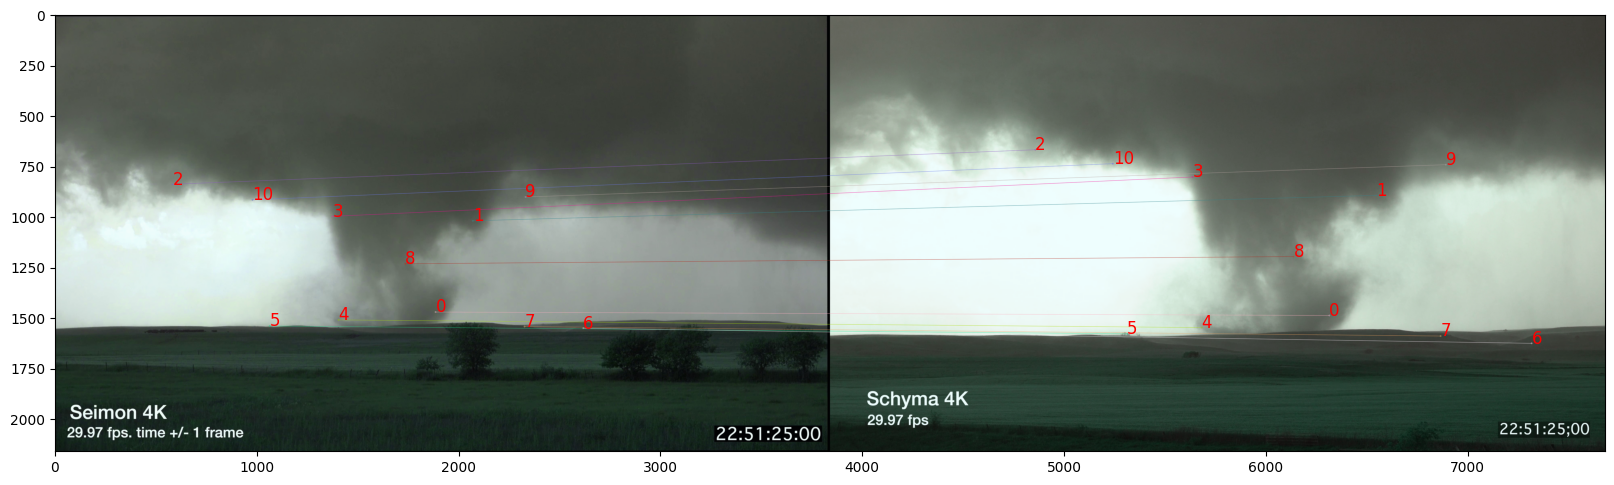

In [ ]:
# Draw the matches between the images
img_matches = cv2.drawMatches(img1, [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in pts1], 
                              img2, [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in pts2], 
                              [cv2.DMatch(i, i, 0) for i in range(len(pts1))], None)

# Display the matches
plt.figure(figsize=(20, 10))
plt.imshow(img_matches)

# Annotate the points with their index numbers
for i, (pt1, pt2) in enumerate(zip(pts1, pts2)):
    plt.text(pt1[0], pt1[1], str(i), color='red', fontsize=12)
    plt.text(pt2[0] + img1.shape[1], pt2[1], str(i), color='red', fontsize=12)

plt.show()

Text(0.5, 1.0, 'Disparity')

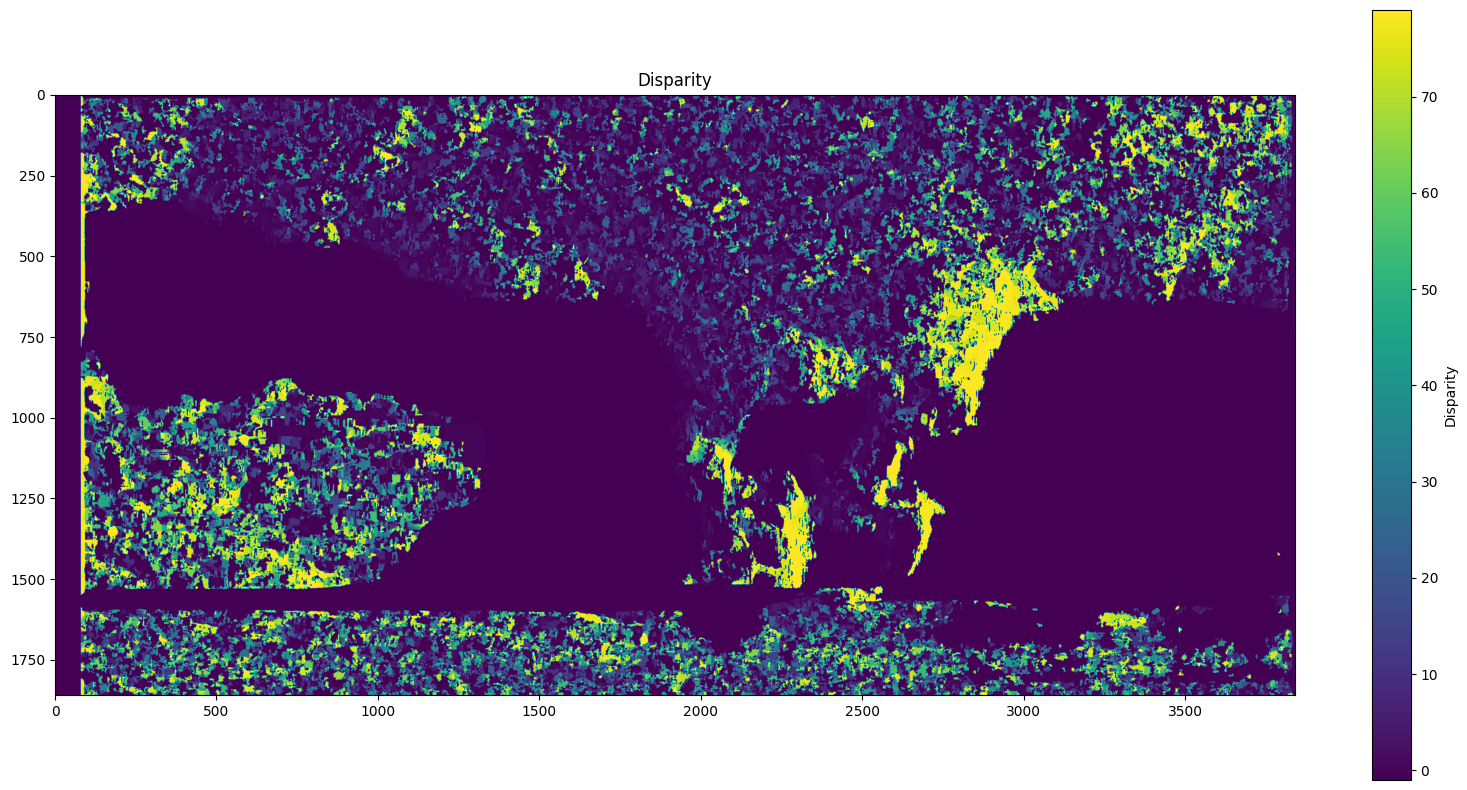

In [11]:
# Proceed with disparity computation (unchanged from previous code)
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16 * 5,
    blockSize=25,
    P1=8 * 3 * 25 ** 2,
    P2=32 * 3 * 25 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=50,
    speckleRange=32
)
disparity = stereo.compute(rectified_left, rectified_right).astype(np.float32) / 16.0
plt.figure(figsize=(20, 10))
plt.imshow(disparity, cmap='viridis')

plt.colorbar(label='Disparity')
plt.title("Disparity")


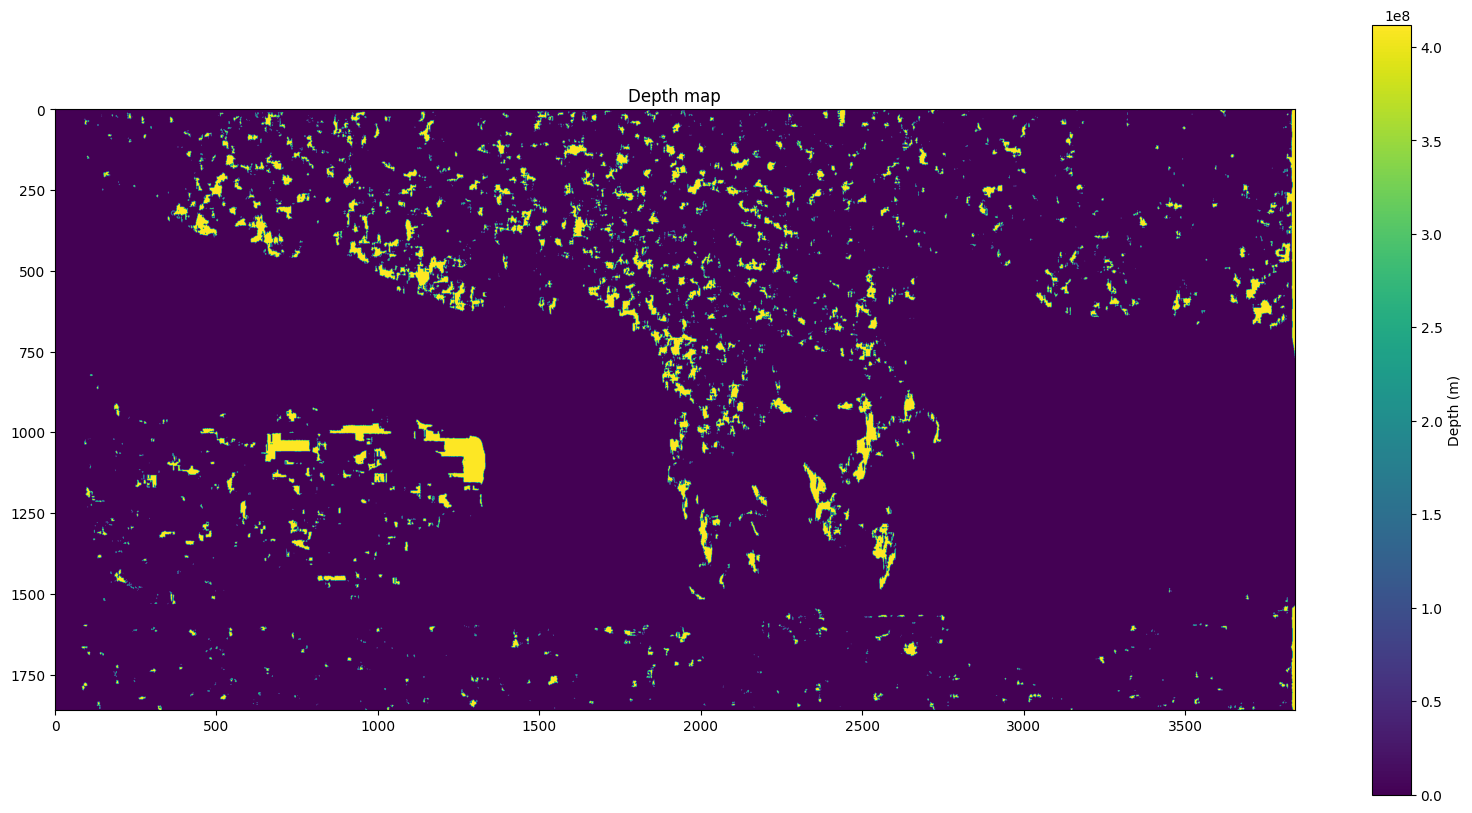

In [14]:
# Calculate depth using the disparity map and the translation vector T
focal_length = K1[0, 0]  # Assuming the focal length is the same for both cameras
baseline = np.linalg.norm(T)  # Distance between the two camera centers

known_distance = 412.02

baseline = baseline*known_distance
# Avoid division by zero by setting disparity values of zero to a small number
disparity[disparity == 0] = 0.0001
# Calculate depth
depth_map = (focal_length * baseline) / disparity

# Display the depth heatmap
plt.figure(figsize=(20, 10))
plt.imshow(depth_map, cmap='viridis')
plt.title("Depth map")
plt.colorbar(label='Depth (m)')
plt.show()